# Current Control for Permanent Magnet Synchronous Machines

This notebook implements three different control strategies: proportional integral (PI) controller, model predictive control (MPC), and a reinforcement learning (RL) for current control of a Permanent Magnet Synchronous Motor (PMSM) in the dq reference frame.

## PMSM Model and Environment Definition

The representation of a a control scheme for a PMSM consists of the motor, an inverter, pulse width modulation, dq-abc transformations, measurements, references, and a controller to follow those references.
<div style="text-align: center">
  <img src="./images/General_Control_Scheme.png" alt="Control Scheme" />
</div>

However, we will work with a simplified version of this system that does not take into a account the inverter, PWM, and dq-abc transformations. 
<div style="text-align: center">
  <img src="./images/General_Control_Scheme_dq.png" alt="Control Scheme" />
</div>
Finally, the "Controller" block is going to be implemented using a PI, MPC, and RL aproach.

# Model
The model of a PMSM in dq-coordinates is the following:
$$
\begin{align*}
V_d &= RI_d + \dfrac{d\lambda_d}{dt} - \omega_e\lambda_q,\\
V_q &= RI_q + \dfrac{d\lambda_q}{dt} + \omega_e\lambda_d,
\end{align*}
$$
where $R$ is the stator resistance, $V_{dq}$ and $I_{dq}$ are the phase voltage and current respectively in dq-coordinates, and the flux linkages are defined as:
$$
\begin{align*}
\lambda_d &= L_dI_d + \lambda_{\mathrm{PM}}\\
\lambda_q &= L_qI_q,
\end{align*}
$$
where $L_{dq}$ is the inductance in dq-coordinates, and $\lambda_{PM}$ is the flux linkage due to the permanent magnets. This is equivalent to:
$$
\begin{align*}
V_d &= RI_d + L_d\dfrac{dI_d}{dt} - \omega_eL_qI_q\\
V_q &= RI_q + L_q\dfrac{dI_q}{dt} + \omega_e(L_dI_d + \lambda_{\mathrm{PM}}),
\end{align*}
$$

The state-space representation is
$$
\begin{align*}
\begin{bmatrix} \dfrac{dI_d}{dt} \\[6pt] \dfrac{dI_q}{dt} \end{bmatrix} &= \begin{bmatrix} -\frac{R}{L_d} & \frac{\omega_e L_q}{L_d}\\[6pt] -\frac{R}{L_q} & -\frac{\omega_e L_d}{L_q} \end{bmatrix}\begin{bmatrix} I_d \\[6pt] I_q \end{bmatrix} + \begin{bmatrix} \frac{1}{L_d} & 0\\[6pt] 0 & \frac{1}{L_q} \end{bmatrix}\begin{bmatrix} V_d \\[6pt] V_q \end{bmatrix} + \begin{bmatrix} 0 \\[6pt] -\frac{\omega_e\lambda_{PM}}{L_q} \end{bmatrix}
\end{align*}
$$

In [1]:
import time
import numpy as np
import pandas as pd
import gymnasium as gym
import ipywidgets as widgets
from IPython.display import display

from environment import EnvPMSM
from controllers import MPCController
from utils import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Register gym environment
gym.register(
    id="EnvPMSM",
    entry_point=EnvPMSM,
)

# %matplotlib widget
figsize = (10, 6)

# Environment
In order to define this representation to work for any controller, the system is defined by using a Gymnasium (from Farama Foundation) environment template with the following class methods:

- \_\_init\_\_: Parameter initialization and definition of action and observation space.
- step: Single step for a discrete-time system representation.
- reset: Initial conditions for simulation for each episode.

The simulation sampling frequency is $10$ [kHz], the simulation consists of $200$ steps, the current is limited to $200$ [A], the DC-bus voltage is $1200$ [V], and the maximum voltage magnitude is limited by a sinusoidal pulse width modulation (SPWM) approach $V_{DC}/2 = 600$ [V].

In [2]:
sys_params = {
    "dt": 1 / 10e3,             # Simulation step time [s]
    "r": 29.0808e-3,            # Phase Stator Resistance [Ohm]
    "ld": 0.91e-3,              # D-axis Inductance [H]
    "lq": 1.17e-3,              # Q-axis Inductance [H]
    "lambda_PM": 0.172312604,   # Flux-linkage due to permanent magnets [Wb]
    "we": 50*2*np.pi,           # Nominal speed [rad/s]
    "vdc": 1200,                # DC bus voltage [V]
    "sim_steps": 200,           # Simulation steps
    "i_max": 200,               # Maximum current [A]
    "id_ref": -10.0,            # Reference d-axis current [A]
    "iq_ref": 100.0             # Reference q-axis current [A]
}
sim_plot_steps = 20             # Simulation plot steps

In [3]:
# Create environment instance
env = gym.make("EnvPMSM", sys_params=sys_params)
base_env = env.unwrapped

## Control Metrics

To compare the performance of the different controllers, some metrics will be defined:

$$
\begin{aligned}
&\begin{array}{ccc}
\hline \hline \text { Name } & \text { Function name } & \text { Equation } \\
\hline \text{Steady-state relative error} & \texttt{error\_r} & \displaystyle\frac{1}{5}\sum_{k=T_f-5}^{T_f} \frac{|I_{d,k} - I_{d,\mathrm{ref}}|}{I_{d,\mathrm{ref}}} + \frac{|I_{q,k} - I_{q,\mathrm{ref}}|}{I_{q,\mathrm{ref}}} \\
\text{Steady-state absolute error} & \texttt{error} & \displaystyle\frac{1}{5}\sum_{k=T_f-5}^{T_f} |I_{d,k} - I_{d,\mathrm{ref}}| + |I_{q,k} - I_{q,\mathrm{ref}}| \\
\text{Sum of squared errors (SSE)} & \texttt{sse} & \displaystyle\sum_{k=0}^{T_f} (I_{d,k} - I_{d,\mathrm{ref}})^2 + (I_{q,k} - I_{q,\mathrm{ref}})^2 \\
\text{Control energy} & \texttt{control\_energy} & \displaystyle\Delta t\sum_{k=0}^{T_f} V_{d,k}^2 + V_{q,k}^2 \\
\text{Settling time} & \texttt{settling\_time} & \displaystyle\text{Find time where the signal stays at 95\% the reference value}\\
\text{Overshoot} & \texttt{overshoot} & \displaystyle\max I_{dq}, \text{ valid if the value is higher than $I_{dq,ref}$}\\
\text{Undershoot} & \texttt{undershoot} & \displaystyle\min I_{dq}, \text{ valid if the value is lower than $I_{dq,0}$} \\
\text{Computation time} & \texttt{computation\_time} & \displaystyle\text{Time it takes to compute each signal} \\
\hline
\end{array}
\end{aligned}
$$

where $T_f$ is the ending time of the simulation.
<!-- $$
\begin{align*}
\text{Steady-state relative error } &= \texttt{error\_r} &= \sum_{k=T_f-20}^{T_f} |I_{d,k} - I_{d,\mathrm{ref}}| + |I_{q,k} - I_{q,\mathrm{ref}}|,\\
\text{Steady-state absolute error } &= \texttt{error} &= \sum_{k=T_f-20}^{T_f} |I_{d,k} - I_{d,\mathrm{ref}}| + |I_{q,k} - I_{q,\mathrm{ref}}|,\\
\text{Sum of squared errors (SSE) } &= \texttt{sse} &= \sum_{k=0}^{T_f} (I_{d,k} - I_{d,\mathrm{ref}})^2 + (I_{q,k} - I_{q,\mathrm{ref}})^2,\\
\text{Control energy } &= \texttt{control\_energy} &= \Delta t\sum_{k=0}^{T_f} V_{d,k}^2 + V_{q,k}^2\\
\text{Settling time } &= \texttt{settling\_time} &= \\
\text{Overshoot } &= \texttt{overshoot} &= \\
\text{Undershoot } &= \texttt{undershoot} &= \\
\text{Computation time} &= \texttt{comp\_time} &= 
\end{align*}
$$ -->

In [4]:
class Metrics:
    def __init__(self, idq_ref, dt):
        self.dt = dt                        # Simulation step time [s]
        self.idq_ref = np.array(idq_ref)    # Reference currents in dq-axis [A]

        # Function for matrix-vector substraction and division
        self.mv_sub = lambda matrix, vector: (matrix.transpose() - vector).transpose()
        self.mv_div = lambda matrix, vector: (matrix.transpose() / vector).transpose()


    def error_r(self, idq):
        return 1/5*np.sum(self.mv_div(np.abs(self.mv_sub(idq[:,-5:], self.idq_ref)), self.idq_ref))
    
    def error(self, idq):
        return 1/5*np.sum(np.abs(self.mv_sub(idq[:,-5:], self.idq_ref)))
    
    def sse(self, idq):
        return np.sum(self.mv_sub(idq, self.idq_ref)**2)
    
    def control_energy(self, vdq):
        return self.dt * np.sum(vdq**2)
    
    def settling_time(self, time_vec, signal, stability_threshold=0.05, window_percent=10):

        n_channels = signal.shape[0]
        settling_times = []
        viz_data_list = []

        # Iterate over each channel (column) in the signal array 
        for i in range(n_channels):
            current_signal = signal[i, :]
            s = pd.Series(current_signal)

            # Calculate window size 
            window_size = int((window_percent / 100) * len(s))
            if window_size < 2:
                window_size = 2

            # Calculate moving statistics 
            moving_avg = s.rolling(window=window_size, center=True).mean()
            moving_std = s.rolling(window=window_size, center=True).std()
            
            moving_avg.fillna(method='bfill', inplace=True)
            moving_avg.fillna(method='ffill', inplace=True)
            moving_std.fillna(method='bfill', inplace=True)
            moving_std.fillna(method='ffill', inplace=True)

            # Calculate the rate of change
            signal_abs_mean = np.mean(np.abs(current_signal))
            # Prevent division by zero when calculating settling time
            if signal_abs_mean < 1e-9: signal_abs_mean = 1.0

            avg_rate_of_change = np.abs(np.diff(moving_avg) / signal_abs_mean)
            std_rate_of_change = np.abs(np.diff(moving_std) / signal_abs_mean)

            # Find where the signal becomes stable
            is_unstable = (avg_rate_of_change > stability_threshold) | \
                        (std_rate_of_change > stability_threshold)
            
            unstable_indices = np.where(is_unstable)[0]

            if len(unstable_indices) == 0:
                settling_index = window_size
            else:
                settling_index = unstable_indices[-1] + 1
            
            if settling_index >= len(time_vec):
                settling_time = None
            else:
                settling_time = time_vec[settling_index]
            
            settling_times.append(settling_time)
            
            viz_data = {
                'moving_avg': moving_avg.to_numpy(),
                'moving_std': moving_std.to_numpy(),
                'settling_index': settling_index
            }
            viz_data_list.append(viz_data)

        return np.array(settling_times), viz_data_list
        
    def overshoot(self, idq):
        return np.array([100*np.abs((np.max(i)-iref)/iref) if np.abs(np.max(i)) > np.abs(iref) else np.nan for i, iref in zip(idq, self.idq_ref)])
    
    def undershoot(self, idq):
        return np.array([100*np.abs((np.min(i)-iref)/iref) if np.abs(np.min(i)) < np.abs(i0) else np.nan for i, i0, iref in zip(idq, idq[:,0], self.idq_ref)])
    
    def computation_time(self, controller, controller_inputs):
        start_time = time.perf_counter()
        action = controller(**controller_inputs)
        elapsed_time_s = time.perf_counter() - start_time
        elapsed_time_ms = 1e3*elapsed_time_s

        return action, elapsed_time_ms

In [5]:
metrics = Metrics(np.array([base_env.id_ref, base_env.iq_ref]), base_env.dt)

## PI Controller Implementation

A PI Controller consists of a proportional and integrative part that uses the tracking error to compute the system's inputs:
$$
e_{I_{dq}}(t) = I_{dq,\mathrm{ref}}(t) - I_{dq}(t)
$$
Hence, the inputs to the system are calculated as:
$$
V_{dq}(t) = K_pe_{I_{dq}}(t) + K_i\int_0^t e_{I_{dq}}(t) dt
$$
However, in order to implement this approach in a discrete manner, we need to define the integral using a Riemann approximation:
$$
V_{dq}(k) = K_pe_{I_{dq}}(k) + K_i\Delta t\sum_{j=0}^k e_{I_{dq}}(j)
$$

In [6]:
class PIController:
    def __init__(self, Kp, Ki, Ts, umax):
        self.Kp = Kp                # Proportional gain
        self.Ki = Ki                # Integral gain
        self.Ts = Ts                # Sampling time [s]
        self.umax = umax            # Maximum input [V]
        self.error_sum = np.zeros(2)    # Initialization of error accumulation
        
    def reset(self):
        # Reset error accumulation
        self.error_sum = np.zeros(2)
        
    def control(self, reference, measured):
        # Define error
        error = reference - measured

        # Define error accumulation
        self.error_sum += error * self.Ts
        
        # Compute action "u"
        # u = Kp*e + Ki*Ts*Σe
        u = self.Kp * error + self.Ki * self.error_sum
        
        # Limit action
        u = np.clip(u, -self.umax, self.umax)
        
        return u

Then we define a wrapper to run the controller to use later with slider to choose $K_p$ and $K_i$ gains

In [7]:
# Interactive wrapper function
def run_pi_controller_sim(Kp, Ki, envs, figsize=(10, 5), show=True):
    Ts = base_env.dt
    controller = PIController(Kp=Kp, Ki=Ki, Ts=Ts, umax=base_env.vdc/2)
    table_data = run_simulation(envs=envs, controller=controller, controller_type="PI", metrics=metrics, 
                                figsize=figsize, sim_steps=sim_plot_steps, plot=show)
    
    table = pd.DataFrame(table_data, index=["PI Controller"], columns=columns)
    table = table.fillna("")
    table = table.style \
    .format(precision=3, thousands=".", decimal=",") \
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])

    if show:
        display(table)

    return table_data

Finally we run the PI controller using precomputed gains

In [8]:
# Initial gains for controller
Kp = 3.9932
Ki = Kp*(1-0.8776)/base_env.dt

# Create sliders 
Kp_slider = widgets.FloatSlider(value=Kp, min=0, max=20, step=0.1, description='Kp')
Ki_slider = widgets.FloatSlider(value=Ki, min=0, max=100_000, step=1, description='Ki')

# Connect widgets to function
ui = widgets.HBox([Kp_slider, Ki_slider])
out = widgets.interactive_output(
    run_pi_controller_sim, 
    {
        'Kp': Kp_slider, 
        'Ki': Ki_slider, 
        'envs': widgets.fixed(env),
        'figsize': widgets.fixed(figsize)
    }
)

display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1000x600 with 3 Axes>', '…

## Model Predictive Control Implementation
For a explanation in detail check: [Model Predictive Control System Design and Implementation Using MATLAB](https://link.springer.com/book/10.1007/978-1-84882-331-0)

**Model Predictive Control (MPC)** is a control strategy that uses a model of the system to **predict future behavior** and **optimize control actions** at each time step.


**Key idea:**  
At every control step, MPC:
1. Predicts how the system will evolve over a future horizon using its model.  
2. Computes a sequence of control inputs that minimize a cost function (e.g., tracking error + control effort).  
3. Applies **only the first control input** from the sequence.  
4. Repeats the process at the next time step with updated measurements (receding horizon).


**Main components:**  
- **System model:** Describes how inputs affect future states.  
- **Cost function:** Balances tracking performance and control effort.  
- **Constraints:** Limitations on inputs or states (e.g., voltage, current, speed).  
- **Prediction horizon:** Number of future steps considered in the optimization.  


**Advantages:**  
- Handles **multi-variable** systems naturally.  
- Can explicitly **enforce constraints**.  
- Provides **optimal control actions** over time.


In short, MPC predicts the future and optimizes the next action to keep the system on track while respecting constraints. 

The cost function for this problem looks like:
$$
\min_u{\,(y_N-r)^TP(y_N-r) \,+\, \sum_{k=0}^{N-1}{(y_k-r)^TQ(y_k-r)} \,+\, \sum_{k=0}^{N}{\Delta u_k^TR\Delta u_k}}
$$
where $y$ is the output, $r$ is the reference, $\Delta u$ is the variation of the input, and $Q,P,R$ are weight matrices to balance the different goals.

<div style="text-align: center">
  <img src="./images/MPC_scheme_basic.svg" alt="Control Scheme" />
</div>

In [9]:
# Interactive wrapper function
def run_mpc_controller_sim(Q, P, R, envs, figsize=(10, 5), show=True):
    controller = MPCController(base_env, Q, P, R)
    table_data = run_simulation(envs=envs, controller=controller, controller_type="MPC", metrics=metrics, 
                                figsize=figsize, sim_steps=sim_plot_steps, plot=show)

    table = pd.DataFrame(table_data, index=["MPC"], columns=columns)
    table = table.fillna("")
    table = table.style \
    .format(precision=3, thousands=".", decimal=",") \
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])

    if show:
        display(table)
    
    return table_data

In [10]:
# Initialize controller
Q = 100
P = 10
R = 1

# Create sliders
Q_slider = widgets.FloatSlider(value=Q, min=0, max=200, step=1, description='Q')  # y-r (reference tracking error)
P_slider = widgets.FloatSlider(value=P, min=0, max=2000, step=1, description='P') # y_N-r_N (steady-state reference tracking error)
R_slider = widgets.FloatSlider(value=R, min=0, max=200, step=1, description='R')  # Δu (input difference)

# Connect widgets to function
ui = widgets.HBox([Q_slider, P_slider, R_slider])
out = widgets.interactive_output(
    run_mpc_controller_sim, 
    {
        'Q': Q_slider, 
        'P': P_slider, 
        'R': R_slider, 
        'envs': widgets.fixed(env),
        'figsize': widgets.fixed(figsize)
    }
)
display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<pandas.io.formats.style.Styler at 0x2…

## 3.- Deep Deterministic Policy Gradient (DDPG) Implementation
For a explanation in detail visit: [Spinning up OpenAI DDPG](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)

**Deep Deterministic Policy Gradient (DDPG)** is a reinforcement learning algorithm designed for **continuous control problems**.  
It combines ideas from **Q-learning** and **policy gradients** using **deep neural networks**.

**Key idea:**  
DDPG learns two networks — an **Actor** and a **Critic** — that work together:
1. The **Actor** chooses actions given the current state.  
2. The **Critic** evaluates how good those actions are (Q-value).  
3. The Actor is updated to produce actions that maximize the Critic’s predicted Q-values.

**Main components:**  
- **Actor:** Outputs continuous actions based on the current state.  
- **Critic:** Estimates the Q-value $Q(s, a)$ for state–action pairs.  
- **Replay buffer:** Stores past experiences $(s_t, a_t, r_t, s_{t+1})$ and allows random sampling for training.  
- **Target networks:** Smoothed copies of Actor and Critic used to stabilize training.  

**Training process:**  
1. Collect experiences by interacting with the environment.  
2. Store them in the replay buffer.  
3. Sample mini-batches and update the Critic to minimize the Q-value prediction error.  
4. Update the Actor to produce actions that maximize the Critic’s output.  
5. Soft-update the target networks for stability.

**Advantages:**  
- Works well with **continuous** action spaces.  
- Learns directly from raw, nonlinear dynamics.  
- Can be combined with exploration noise for better coverage.

In short, DDPG learns a policy that directly maps states to optimal continuous actions by training an Actor–Critic pair using experience replay.


<div style="text-align: center">
  <img src="./images/Control_problem_DDPG.png" alt="Control Scheme" />
</div>

In [11]:
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
import os

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
model = DDPG("MlpPolicy", env=env, action_noise=action_noise, verbose=1, 
                    tensorboard_log=f"runs/ddpg")

train = False
if train:
    # Create DDPG model
    start_time = time.perf_counter()
    model.learn(total_timesteps=250*sys_params["sim_steps"], log_interval=25)
    elapsed_time = time.perf_counter() - start_time
    
    # Create weights directory if it doesn't exist
    os.makedirs('weights', exist_ok=True)
    model.save(os.path.join('weights', "DDPG_PMSM"))
    # Get vectorized environment
    vec_env = model.get_env()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


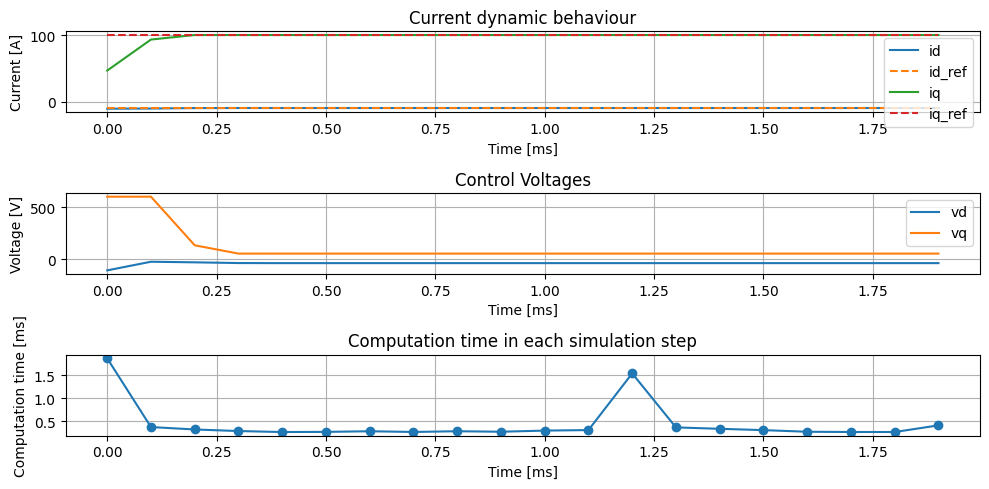

In [12]:
# Interactive wrapper function
def run_DDPG_controller_sim(envs, figsize=(10, 5), show=True):
    # Get vectorized environment
    vec_env = model.get_env()

    seed = 0
    vec_env.seed(seed=seed)

    # Load algorithm weights
    controller = DDPG.load(os.path.join('weights', "DDPG_PMSM"), print_system_info=False)
    table_data = run_simulation(envs=vec_env, controller=controller, controller_type="SB3", metrics=metrics, 
                                figsize=figsize, sim_steps=sim_plot_steps, plot=show)
    
    table = pd.DataFrame(table_data, index=["DDPG"], columns=columns)
    table = table.fillna("")
    table = table.style \
    .format(precision=3, thousands=".", decimal=",") \
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
    
    if show:
        display(table)

    return table_data

_ = run_DDPG_controller_sim(env)

# Comparison

The following table give us information regarding different performance parameters to compare the 3 different controllers implemented in this session.

In [13]:
table_data_PI = run_pi_controller_sim(Kp=Kp_slider.value, Ki=Ki_slider.value, envs=env, show=False)
table_data_MPC = run_mpc_controller_sim(Q=Q_slider.value, P=P_slider.value, R=R_slider.value, envs=env, show=False)
table_data_DDPG = run_DDPG_controller_sim(envs=env, show=False)

table = pd.DataFrame([table_data_PI[0], table_data_MPC[0], table_data_DDPG[0]], index=["PI", "MPC", "DDPG"], columns=columns)
table = table.fillna("")
table = table.style \
.format(precision=3, thousands=".", decimal=",") \
.set_table_styles([
    {"selector": "th", "props": [("text-align", "center")]},
    {"selector": "td", "props": [("text-align", "center")]}
])
display(table)